# Data Preprocessing and Exploration
- Goals here
  - Understand structure of photos
  - extract smile vs non_smile label with respect to photo
  - reorganize photos to pytorch's directory layout (directories for train, val, test and respective subdirectories for each class)
  - check width and height of pictures

### GENKI-4k
- Exactly 4,000 pictures
- files are named from `file0001.jpg` to `file4000.jpg`
- in `labels.txt` first row (starting at 1) corresponds to `file0001.jpg`, second row to file `file0002.jpg`, ..., 4000th row to `file4000.jpg`
- attributes: expression (smile=1, non-smile=0) labels and pose labels (yaw, pitch, and roll,
in radians)

### UCF Selfie Data Set
- 46,836 pictures
- selfie_dataset.txt
  - first rows:
    ```
    00a454da495e11e28a7322000a1fa414_6 3.901  1  1 -1 -1 -1  1 ...
    00cddb96ac4c11e3a30212279ba1b65f_6 4.385  1  1 -1 -1 -1 -1 ...
    01cdd7aa1a1a11e2aaa822000a1fb0dd_6 4.243 -1  1 -1 -1  1 -1 ...
    ```
  - column corresponds to filename without `.jpg`, popularity score, 36 attributes
  - attributes:
    ```
    partial_faces is_female
    baby child teenager youth middle_age senior
    white black asian
    oval_face round_face heart_face
    smiling mouth_open frowning
    wearing_glasses wearing_sunglasses wearing_lipstick
    tongue_out duck_face
    black_hair blond_hair brown_hair red_hair curly_hair straight_hair braid_hair
    showing_cellphone using_earphone using_mirror
    braces wearing_hat
    harsh_lighting dim_lighting
    ```

In [1]:
import pandas as pd

In [2]:
# Loading genki data
genki = pd.read_csv("raw/genki/labels.txt", sep=" ", header=None)
genki.columns = ["smile", "yaw", "pitch", "roll"]
genki["file"] = [f"raw/genki/files/file{i:04d}.jpg" for i in range(1, 4001)]
genki = genki[["file" , "smile"]]
genki.head(), genki.tail()

(                           file  smile
 0  raw/genki/files/file0001.jpg      1
 1  raw/genki/files/file0002.jpg      1
 2  raw/genki/files/file0003.jpg      1
 3  raw/genki/files/file0004.jpg      1
 4  raw/genki/files/file0005.jpg      1,
                               file  smile
 3995  raw/genki/files/file3996.jpg      0
 3996  raw/genki/files/file3997.jpg      0
 3997  raw/genki/files/file3998.jpg      0
 3998  raw/genki/files/file3999.jpg      0
 3999  raw/genki/files/file4000.jpg      0)

In [3]:
# Loading ucf data
ucf = pd.read_csv("raw/ucf/selfie_dataset.txt", sep=" ", header=None)
ucf_attributes = ['partial_faces', 'is_female',
                  'baby', 'child', 'teenager', 'youth', 'middle_age', 'senior',
                  'white', 'black', 'asian',
                  'oval_face', 'round_face', 'heart_face',
                  'smiling', 'mouth_open', 'frowning',
                  'wearing_glasses', 'wearing_sunglasses','wearing_lipstick',
                  'tongue_out', 'duck_face',
                  'black_hair', 'blond_hair', 'brown_hair', 'red_hair',
                  'curly_hair', 'straight_hair', 'braid_hair',
                  'showing_cellphone', 'using_earphone', 'using_mirror',
                  'braces', 'wearing_hat',
                  'harsh_lighting', 'dim_lighting']
ucf.columns = ["image", "popularity"] + ucf_attributes
ucf["file"] = [f"raw/ucf/images/{f}.jpg" for f in ucf["image"]]
ucf = ucf[["file", "smiling"]]
ucf = ucf.rename(columns={"smiling": "smile"})
# Replace -1 in smile column with 0
ucf["smile"] = ucf["smile"].replace(-1, 0)
ucf.head(), ucf.tail()

(                                                file  smile
 0  raw/ucf/images/00a454da495e11e28a7322000a1fa41...      0
 1  raw/ucf/images/00cddb96ac4c11e3a30212279ba1b65...      0
 2  raw/ucf/images/01cdd7aa1a1a11e2aaa822000a1fb0d...      0
 3  raw/ucf/images/024696bead0c11e389d50ec42b3b1b1...      0
 4  raw/ucf/images/026df048221a11e2b52122000a1fa4b...      0,
                                                     file  smile
 46831  raw/ucf/images/fe5ce3cca89311e3873c0e9928917b4...      1
 46832  raw/ucf/images/feb38bc4a20711e3bc5f0e4e836c9c8...      0
 46833  raw/ucf/images/fed5374e66d211e3ad1e12ed570e937...      0
 46834  raw/ucf/images/ff639554890411e2942122000aaa053...      0
 46835  raw/ucf/images/ffb33a90b06911e3b2a4120e4e51d42...      0)

In [4]:
# ucf.loc[ucf["image"] == "924960_214909982052289_1000840486_a"].T

just form little sampling by hand:
- 924330_1420475104878159_610663441_a
  - I'd say smiling, labelled as non smiling
- 924347_592735714155475_142756016_a
  - labelled as non smiling, id say smiling
- 924945_655595334513490_324125024_a clearly smiling
  - not labelled as smiling
--> what is a smile? It seems here, subtle smiles might not be classified as smile etc...

In [5]:
# Count the number of smiles in percent
genki_count = genki["smile"].value_counts(normalize=True)
ucf_count = ucf["smile"].value_counts(normalize=True)
genki_count, ucf_count

(smile
 1    0.5405
 0    0.4595
 Name: proportion, dtype: float64,
 smile
 0    0.739367
 1    0.260633
 Name: proportion, dtype: float64)

--> genki is relatively (54 % smiling vs 46 % non-smiling), ucf is imbalanced (26 % smiling, 74 % non smiling)

In [6]:
# Sample 5 images of each class in each dataset
genki_sample = ( genki[genki["smile"] == 1].sample(5, random_state=42) ) \
    .merge( genki[genki["smile"] == 0].sample(5, random_state=7), how="outer")

ucf_sample = ( ucf[ucf["smile"] == 1].sample(5, random_state=42) ) \
    .merge( ucf[ucf["smile"] == 0].sample(5, random_state=7), how="outer")

genki_sample, ucf_sample

(                           file  smile
 0  raw/genki/files/file1135.jpg      1
 1  raw/genki/files/file0671.jpg      1
 2  raw/genki/files/file0966.jpg      1
 3  raw/genki/files/file1755.jpg      1
 4  raw/genki/files/file2059.jpg      1
 5  raw/genki/files/file3362.jpg      0
 6  raw/genki/files/file2626.jpg      0
 7  raw/genki/files/file3375.jpg      0
 8  raw/genki/files/file2881.jpg      0
 9  raw/genki/files/file3690.jpg      0,
                                                 file  smile
 0  raw/ucf/images/10251508_260372467476414_155750...      1
 1  raw/ucf/images/1171156_1469180603313686_177521...      1
 2  raw/ucf/images/10005490_725380554151590_589352...      1
 3  raw/ucf/images/928513_544081942374168_25366438...      1
 4  raw/ucf/images/10011252_225940547602621_116092...      1
 5  raw/ucf/images/1516895_503023436487587_1200684...      0
 6  raw/ucf/images/10013275_322330934597475_188108...      0
 7  raw/ucf/images/1530608_633190280094289_1525167...      0
 8  raw/uc

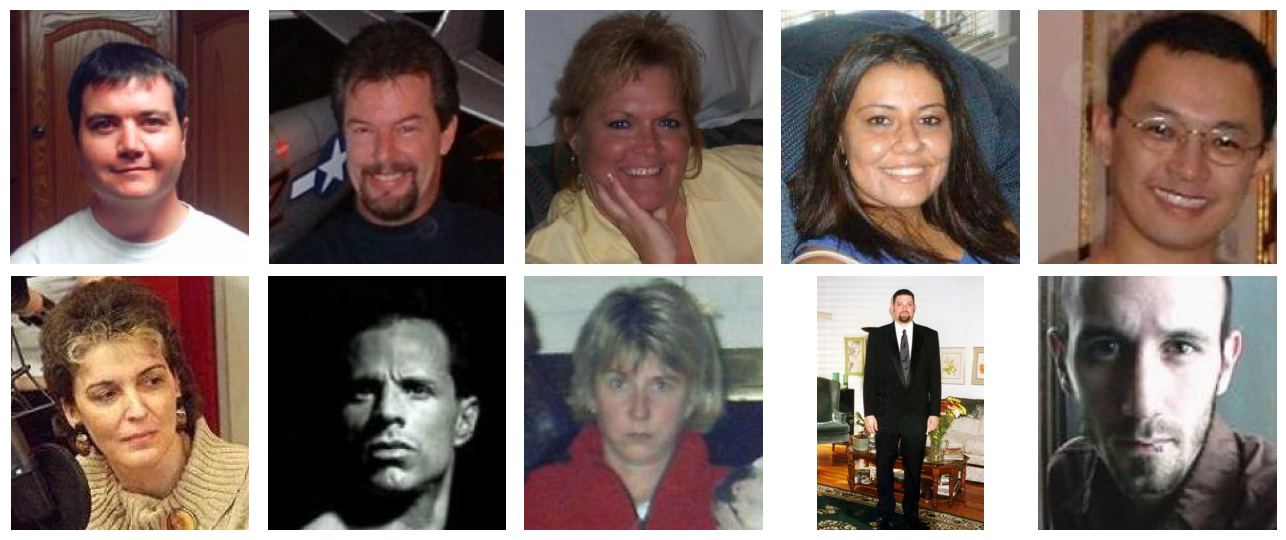

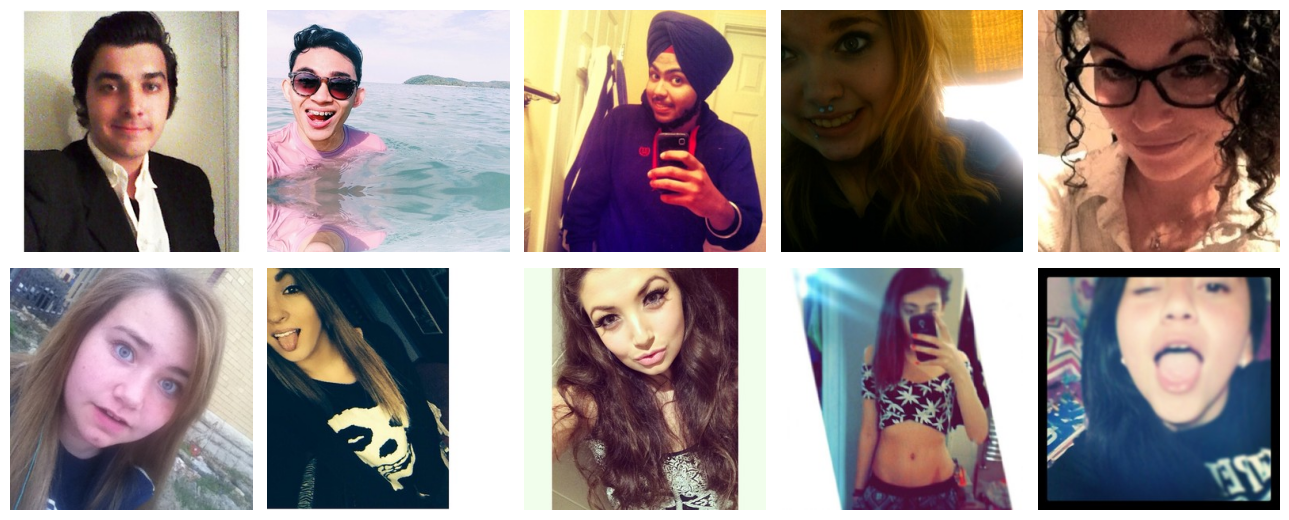

In [7]:
# Display the images of genki_sample in a grid
from PIL import Image
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(13, 5.5))
for i, row in genki_sample.iterrows():
    img = Image.open(row["file"])
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis("off")
    # axs[i // 5, i % 5].set_title(row["smile"])
fig.tight_layout()
plt.savefig("genki_sample.jpg")

fig, axs = plt.subplots(2, 5, figsize=(13, 5.5))
for i, row in ucf_sample.iterrows():
    img = Image.open(row["file"])
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis("off")
    # axs[i // 5, i % 5].set_title(row["smile"])
fig.tight_layout()
plt.savefig("ucf_sample.jpg")

In [8]:
print(genki.shape, ucf.shape)
# Combine both datasets
data = pd.concat([genki, ucf], ignore_index=True)
print(data.shape)

(4000, 2) (46836, 2)
(50836, 2)


In [9]:
data["smile"].value_counts()

smile
0    36467
1    14369
Name: count, dtype: int64

### Setup directory tree

In [10]:
import os

folder_structure = {
    'dataset': {
        'train': {
            'smile': [],
            'non_smile': []
        },
        'val': {
            'smile': [],
            'non_smile': []
        },
        'test': {
            'smile': [],
            'non_smile': []
        }
    }
}

def create_folders(base_path, structure):
    for folder, content in structure.items():
        folder_path = os.path.join(base_path, folder)
        os.makedirs(folder_path, exist_ok=True)
        if isinstance(content, dict):
            create_folders(folder_path, content)


create_folders('.', folder_structure)

### Shuffle Data, Split, Copy To Destination
Split: 70 - 15 - 15

In [11]:
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
# split column into train, val, test
data_shuffled["split"] = pd.qcut(data_shuffled.index,
                                 q=[0, 0.7, 0.85, 1],
                                 labels=["train", "val", "test"])
data_shuffled["split"].value_counts(normalize=True)

split
train    0.699996
test     0.150012
val      0.149992
Name: proportion, dtype: float64

In [13]:
import shutil
from tqdm import tqdm

# Copy images to the correct folder (uncomment shutil.copy...)
for i, row in tqdm(data_shuffled.iterrows(), total=data_shuffled.shape[0]):
    smile = "smile" if row["smile"] == 1 else "non_smile"
    split = row["split"]
    src = row["file"]
    dst = os.path.join("dataset", split, smile, os.path.basename(src))
    # shutil.copy(src, dst)

100%|██████████| 50836/50836 [13:44<00:00, 61.67it/s]


--> This basically is our dataset. For work with google colab we'll zip it up...